# Introduction

Based on the discussion we have with Andre on Pilot-Spark's Throughput on a Single node, I created 4 configurations that are the following:

1. Spark context is created at every iteration of the experiment and closed after the execution (Style 1)
2. Spark context is created once at the beginning and used for the whole experiment (Style 2)
3. Spark configuration and context are created once at the beginning and used for the whole experiment (Style 3)
4. Spark configuration is created once and the context is created at every iteration of the experiment and closed after the execution (Style 4)

In all case spark-submit was used to submit the application. The Code of each style can be found in the appendix.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Spark Section
tidy = pd.DataFrame(columns=['Run','Tasks','Style','Time'])
Tasks=[2**i for i in range(0,18)]
style1=np.zeros((18,10))
for i in range(0,10):
    times=np.load('SingleNode/Wrangler/style1/timings_%d.npz.npy'%i)
    style1[:,i]=times[:,1]-times[:,0]
    tidy_frameworks = pd.DataFrame(columns=['Run','Tasks','Style','Time'])
    tidy_frameworks['Run']=[i+1 for _ in range(0,18)]
    tidy_frameworks['Tasks']=Tasks
    tidy_frameworks['Style']=1
    tidy_frameworks['Time']=style1[:,i].tolist()
    tidy = tidy.append(tidy_frameworks,ignore_index=True)
    
style2=np.zeros((18,10))
for i in range(0,10):
    times=np.load('SingleNode/Wrangler/style2/timings_%d.npz.npy'%i)
    style2[:,i]=times[:,1]-times[:,0]
    tidy_frameworks = pd.DataFrame(columns=['Run','Tasks','Style','Time'])
    tidy_frameworks['Run']=[i+1 for _ in range(0,18)]
    tidy_frameworks['Tasks']=Tasks
    tidy_frameworks['Style']=2
    tidy_frameworks['Time']=style2[:,i].tolist()
    tidy = tidy.append(tidy_frameworks,ignore_index=True)
    
style3=np.zeros((18,10))
for i in range(0,10):
    times=np.load('SingleNode/Wrangler/style3/timings_%d.npz.npy'%i)
    style3[:,i]=times[:,1]-times[:,0]
    tidy_frameworks = pd.DataFrame(columns=['Run','Tasks','Style','Time'])
    tidy_frameworks['Run']=[i+1 for _ in range(0,18)]
    tidy_frameworks['Tasks']=Tasks
    tidy_frameworks['Style']=3
    tidy_frameworks['Time']=style3[:,i].tolist()
    tidy = tidy.append(tidy_frameworks,ignore_index=True)
    
style4=np.zeros((18,10))
for i in range(0,10):
    times=np.load('SingleNode/Wrangler/style4/timings_%d.npz.npy'%i)
    style4[:,i]=times[:,1]-times[:,0]
    tidy_frameworks = pd.DataFrame(columns=['Run','Tasks','Style','Time'])
    tidy_frameworks['Run']=[i+1 for _ in range(0,18)]
    tidy_frameworks['Tasks']=Tasks
    tidy_frameworks['Style']=4
    tidy_frameworks['Time']=style4[:,i].tolist()
    tidy = tidy.append(tidy_frameworks,ignore_index=True)

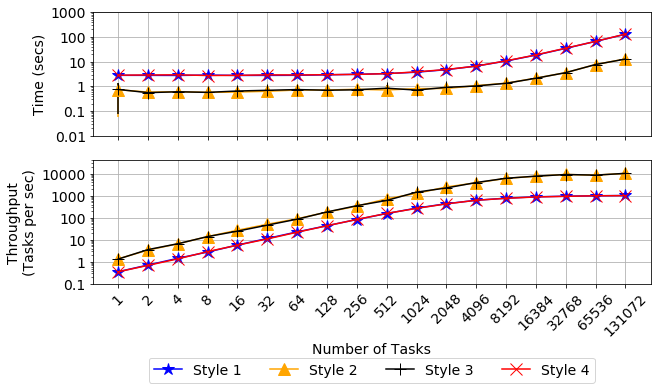

In [3]:
fig,axes = plt.subplots(nrows=2,ncols=1,sharex=True)
fig.set_size_inches(10,5)
axes[0].errorbar(Tasks,style1.mean(axis=1),yerr=style1.std(axis=1),marker='*',label='Style 1',color='b', markersize=12)
axes[0].errorbar(Tasks,style2.mean(axis=1),yerr=style2.std(axis=1),marker='^',label='Style 2',color='orange', markersize=12)
axes[0].errorbar(Tasks,style3.mean(axis=1),yerr=style3.std(axis=1),marker='+',label='Style 3',color='k', markersize=12)
axes[0].errorbar(Tasks,style4.mean(axis=1),yerr=style4.std(axis=1),marker='x',label='Style 4',color='r', markersize=12)
axes[0].set_yscale('log',basey=10)
#locs,labels = axes[0].yticks()
axes[0].set_yticklabels(['0.001','0.01','0.1','1','10','100','1000','10000'],fontsize=14)
axes[0].set_ylim([0.01,1000])
axes[0].set_xscale('log',basex=2)
axes[0].grid('on')
axes[0].set_ylabel('Time (secs)',fontsize=14)
axes[0].set_xticks(Tasks[3:])
axes[0].set_xticklabels(['8','16','32','64','128','256','512','1024','2048','4096','8192','16384','32768','65536','131072'],fontsize=14)

axes[1].plot(Tasks,Tasks/style1.mean(axis=1),'*-',label='Style 1',color='b', markersize=12)
axes[1].plot(Tasks,Tasks/style2.mean(axis=1),'^-',label='Style 2',color='orange', markersize=12)
axes[1].plot(Tasks,Tasks/style3.mean(axis=1),'+-',label='Style 3',color='k', markersize=12)
axes[1].plot(Tasks,Tasks/style4.mean(axis=1),'x-',label='Style 4',color='r', markersize=12)
axes[1].legend(fontsize=14)
axes[1].set_yscale('log',basey=10)
#locs,labels = plt.yticks()
#plt.yticks(locs,['0.001','0.01','0.1','1','10','100','1000','10000'])
#plt.ylim([0.01,1000])
axes[1].set_xscale('log',basex=2)
axes[1].grid('on')
axes[1].set_xlabel('Number of Tasks',fontsize=14)
axes[1].set_ylabel('Throughput\n(Tasks per sec)',fontsize=14)
axes[1].set_ylim([0.1,40000])
axes[1].set_yticks([0.1,1,10,100,1000,10000])
axes[1].set_yticklabels(['0.1','1','10','100','1000','10000'],fontsize=14)
axes[1].set_xticks(Tasks)
axes[1].set_xticklabels(['1','2','4','8','16','32','64','128','256','512','1024','2048','4096','8192','16384','32768','65536','131072'],fontsize=14,rotation=45)
axes[1].legend(fontsize=14,bbox_to_anchor=(0., -0.8, 1,0), loc='lower center',ncol=4, borderaxespad=0.)

Styles 1 and 3 are the ones that the context is created and destroyed every time. As a result we can assume that this operation, although is not included in the timing results creates the overhead in the execution.

# Appendix

## Style 1
```
import sys
from pyspark import SparkContext
from datetime import datetime
import time
import numpy as np
import subprocess


if __name__=="__main__":

    tasks = [1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192,16384,32768,65536,131072]
    for i in range(0,10):
        timings=np.zeros((18,2))
        for taskNum in tasks:
            sc = SparkContext(appName="ThroughputTest")
            rdd = sc.parallelize(range(taskNum))
            start_time = time.time()
            rdd.map(lambda a: subprocess.check_output(['/bin/hostname'])).saveAsTextFile("/work/03170/tg824689/wrangler/SparkSingleNode/style1/test_%d_%d.out"%(i,taskNum))
            end_time= time.time()
            sc.stop()
            print("Iteation %d Spark-2.1.1, %d, Runtime, %.4f"%(i+1, taskNum, (end_time-start_time)))
            timings[tasks.index(taskNum),0]=start_time
            timings[tasks.index(taskNum),1]=end_time
        np.save('style1/timings_%d.npz.npy'%i,timings)
```

## Style 2
```
import sys
from pyspark import SparkContext
from datetime import datetime
import time
import numpy as np
import subprocess


if __name__=="__main__":
    sc = SparkContext(appName="ThroughputTest")
    tasks = [1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192,16384,32768,65536,131072]
    
    for i in range(0,10):
        timings=np.zeros((18,2))
        for taskNum in tasks:
            rdd = sc.parallelize(range(taskNum))
            start_time = time.time()
            rdd.map(lambda a: subprocess.check_output(['/bin/hostname'])).saveAsTextFile("/work/03170/tg824689/wrangler/SparkSingleNode/style2/test_%d_%d.out"%(i,taskNum))
            end_time= time.time()
            print("Iteation %d Spark-2.1.1, %d, Runtime, %.4f"%(i+1, taskNum, (end_time-start_time)))
            timings[tasks.index(taskNum),0]=start_time
            timings[tasks.index(taskNum),1]=end_time
        np.save('style2/timings_%d.npz.npy'%i,timings)
```

## Style 3
```
import sys
from pyspark import SparkContext,SparkConf
from datetime import datetime
import time
import sys
import numpy as np
import subprocess


if __name__=="__main__":
    conf = SparkConf().setAppName("SparkTest").setMaster("spark://%s:7077"%sys.argv[1])
    sc = SparkContext(conf=conf)
    tasks = [1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192,16384,32768,65536,131072]
    
    for i in range(0,10):
        timings=np.zeros((18,2))
        for taskNum in tasks:
            rdd = sc.parallelize(range(taskNum))
            start_time = time.time()
            rdd.map(lambda a: subprocess.check_output(['/bin/hostname'])).saveAsTextFile("/work/03170/tg824689/wrangler/SparkSingleNode/style3/test_%d_%d.out"%(i,taskNum))
            end_time= time.time()
            print("Iteation %d Spark-2.1.1, %d, Runtime, %.4f"%(i+1, taskNum, (end_time-start_time)))
            timings[tasks.index(taskNum),0]=start_time
            timings[tasks.index(taskNum),1]=end_time
        np.save('style3/timings_%d.npz.npy'%i,timings)
```

## Style 4
```
import sys
from pyspark import SparkContext,SparkConf
from datetime import datetime
import time
import sys
import numpy as np
import subprocess


if __name__=="__main__":
    conf = SparkConf().setAppName("SparkTest").setMaster("spark://%s:7077"%sys.argv[1])

    tasks = [1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192,16384,32768,65536,131072]
    
    for i in range(0,10):
        timings=np.zeros((18,2))
        for taskNum in tasks:
            sc = SparkContext(conf=conf)
            rdd = sc.parallelize(range(taskNum))
            start_time = time.time()
            rdd.map(lambda a: subprocess.check_output(['/bin/hostname'])).saveAsTextFile("/work/03170/tg824689/wrangler/SparkSingleNode/style4/test_%d_%d.out"%(i,taskNum))
            end_time= time.time()
            sc.stop()
            print("Iteation %d Spark-2.1.1, %d, Runtime, %.4f"%(i+1, taskNum, (end_time-start_time)))
            timings[tasks.index(taskNum),0]=start_time
            timings[tasks.index(taskNum),1]=end_time
        np.save('style4/timings_%d.npz.npy'%i,timings)
```